In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [3]:
# Original Data
train = pd.read_csv('data/train_1.csv')
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


# Data Wrangling

Each row of the column is a seperate time series of view counts for each day from 07-01-2015 to 12-31-2016. The Page column has data for the Wikipedia page, which I would like to split up into seperate columns of page attributes for easier analysis. There is also missing data, and I will fill those in with zeroes for the time being. 

In [ ]:
# Fill the missing values with 0
train = train.fillna(0)

# Create attribute columns (project, access type, and agent) from the Page feature
project = []
access = []
agent = []
for i in train.Page:
    project.append(i.split('_')[-3])
    access.append(i.split('_')[-2])
    agent.append(i.split('_')[-1])
train.insert(loc=1, column='Project', value=project)
train.insert(loc=2, column='Access', value=access)
train.insert(loc=3, column='Agent', value=agent)

I see that the Project column contains the language of the Wikipedia page, and using regular expressions, I extract the page language and create a new Language column in the dataframe.

In [5]:
# Create a function to extract the language of the page from the project, and add a column for language
def get_lang(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][:2]
    return 'none'

train.insert(loc=4, column='Language', value=train.Page.map(get_lang))

I create columns for the mean view count, max view count, and date of the max view count for each time series.

In [ ]:
# Add columns for the mean and max views of each row, and a column for the date on which the max views occured
mean_views = train.iloc[:, 5:].mean(axis=1)
max_views = train.iloc[:, 5:].max(axis=1)
max_view_date = train.iloc[:, 5:].idxmax(axis=1)

train.insert(loc=5, column='mean_views', value=mean_views)
train.insert(loc=6, column='max_views', value=max_views)
train.insert(loc=7, column='max_view_date', value=max_view_date)

# Data Visualization

I am interested in seeing if there are any specific dates that many pages attained their maximum view count over the period, and I plot a bar graph for the dates that had over 500 pages that attained their maximum views. 

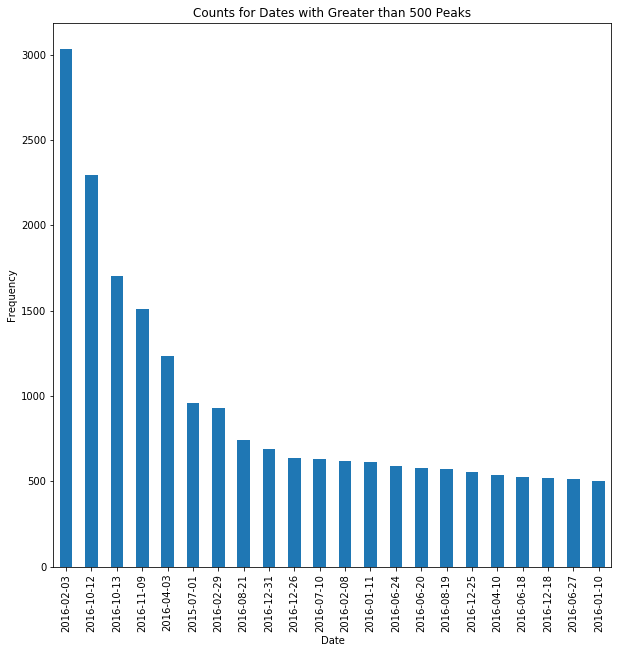

In [19]:
# Plot the dates that achieved the max views greater than 500 times for any page
fig = plt.figure(1,figsize=[10,10])
val_counts_max_date = train.max_view_date.value_counts()
val_counts_max_date[val_counts_max_date > 500].plot('bar')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Counts for Dates with Greater than 500 Peaks')
plt.show()

There doesn't seem to be any significance to the dates with high maximum view counts, and there is no discernable pattern to them. Instead, I will try to split the data by their features and plot a time series of the mean page counts. First, I start with the languages.

In [74]:
# Create a function that splits the data by a feature, and evaluates the split datasets by date using a specified function
def feature_evaluation(feature, func):
    vals = train[feature].unique()
    df_dict = {}
    for val in vals:
        df_dict[val] = train[train[feature]==val].drop(feature, axis=1)
    feature_agg = {}
    for val in vals:
        feature_agg[val] = df_dict[val].iloc[:, 7:].apply(func, axis=0)
    return df_dict, feature_agg

# Split the data by language, and evaluate the mean for each date
lang_dict, lang_mean = feature_evaluation('Language', np.mean)

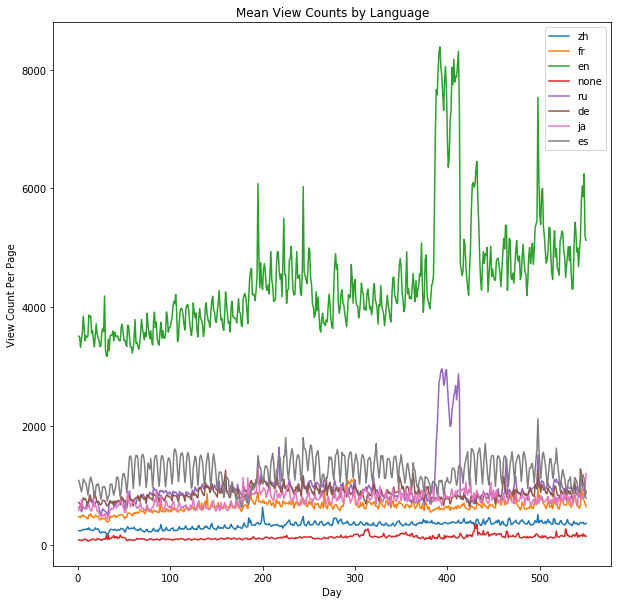

In [82]:
# Create a function that plots the time series of the evaluated datasets
def plot_trend(feature_agg, excluded_keys=[]):
    fig = plt.figure(1, figsize=[10,10])
    feature_agg_copy = feature_agg.copy()
    for key in excluded_keys:
        del feature_agg_copy[key]
    for feature in feature_agg_copy:
        plt.plot(range(1, len(feature_agg[feature]) + 1), feature_agg[feature], label=feature)
        
# Plot the mean view counts by language
plot_trend(lang_mean)
plt.xlabel('Day')
plt.ylabel('View Count Per Page')
plt.title('Mean View Counts by Language')
plt.legend()
plt.show()

There are seven languages present in the data: Chinese, French, English, Russian, German, Japanese and Spanish, as well as category with no language, which seems to be reserved for media pages like images. The mean view counts by language seem to have their own trends, but have similar spikes between some of them, namely the English and Russian sets. However, the English page counts dominate over the rest of the languages, so I will plot the rest of the languages separately from English series.

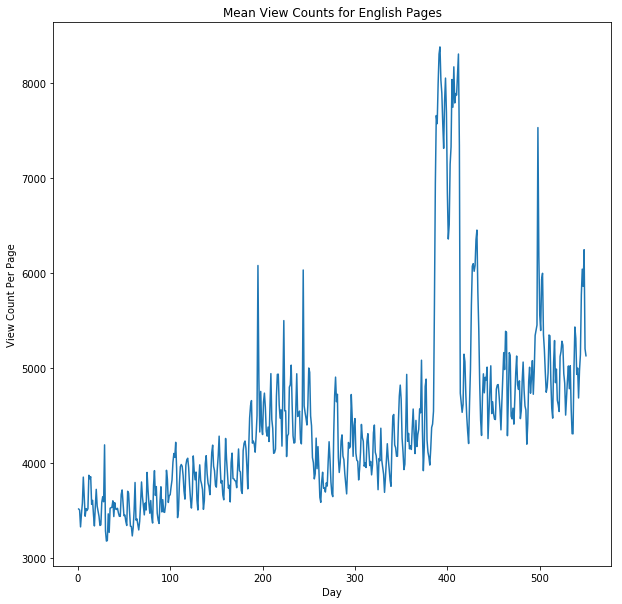

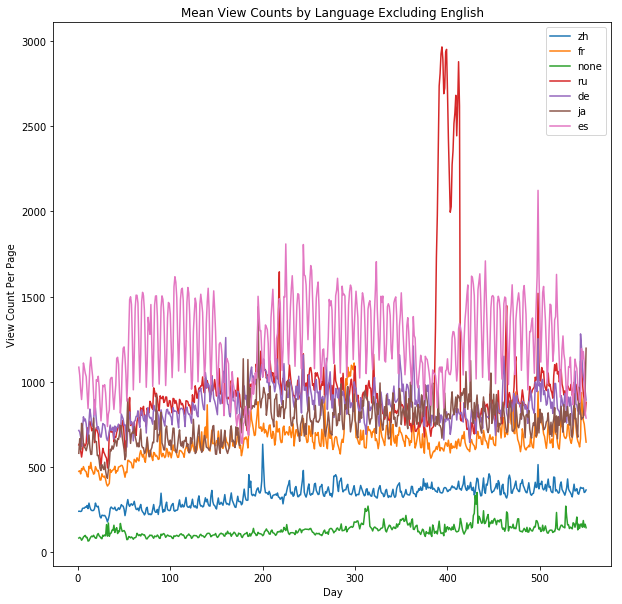

In [83]:
# Plot only the mean view counts for English Pages
fig = plt.figure(1, figsize=[10,10])
plt.plot(range(1, len(lang_sums['en']) + 1), lang_sums['en'])
plt.xlabel('Day')
plt.ylabel('View Count Per Page')
plt.title('Mean View Counts for English Pages')
plt.show()

# Plot the mean view counts for all languages except for English
plot_trend(lang_sums, ['en'])
plt.xlabel('Day')
plt.ylabel('View Count Per Page')
plt.title('Mean View Counts by Language Excluding English')
plt.legend()
plt.show()

Looking at the seperated plots, the Russian and English data do seem to follow similar patterns, especially around the 400 day mark. The rest of the languages don't seem to have similar relationships to any of the other language sets, but they do all have their own spikes and general trends. 

Now, we plot the times series of the mean view counts by how the pages were accessed.

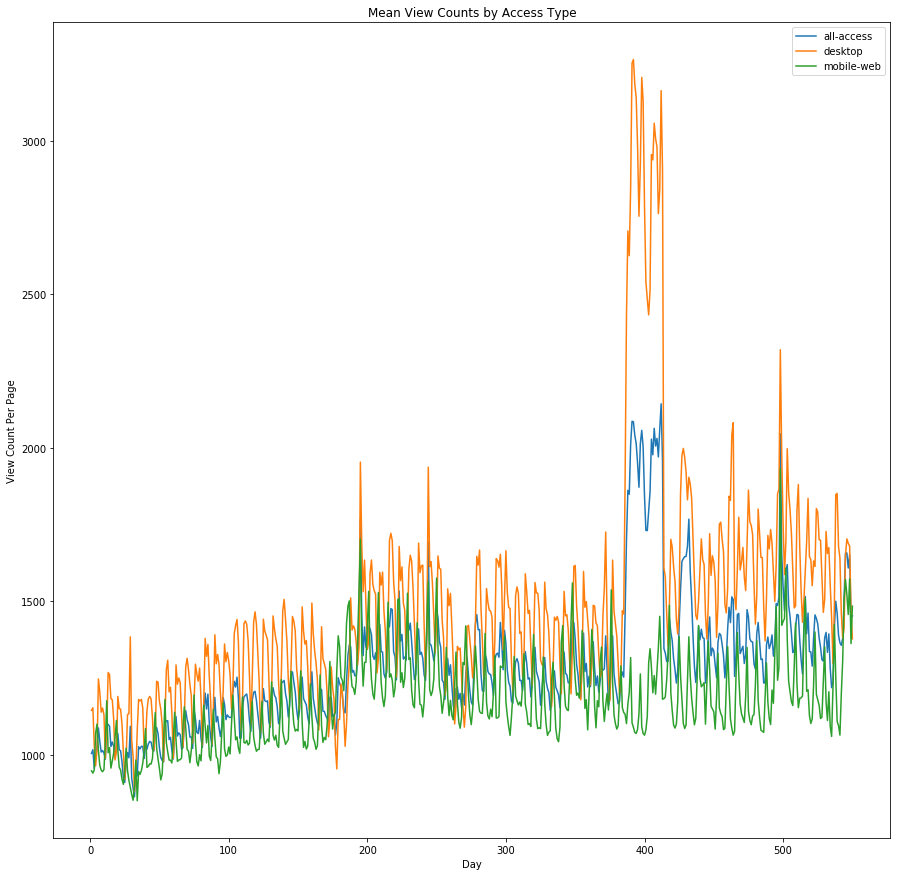

In [79]:
access_dict, access_mean = feature_evaluation('Access', np.mean)

plot_trend(access_mean)
plt.xlabel('Day')
plt.ylabel('View Count Per Page')
plt.title('Mean View Counts by Access Type')
plt.legend()
plt.show()

There are three access types: mobile, desktop, and all access. The plots seem to follow similar patterns for all three categories, with desktop access strangely having the highest mean view counts. The desktop and all access series show the same spike at around the 400 day mark that the language plot featured. 

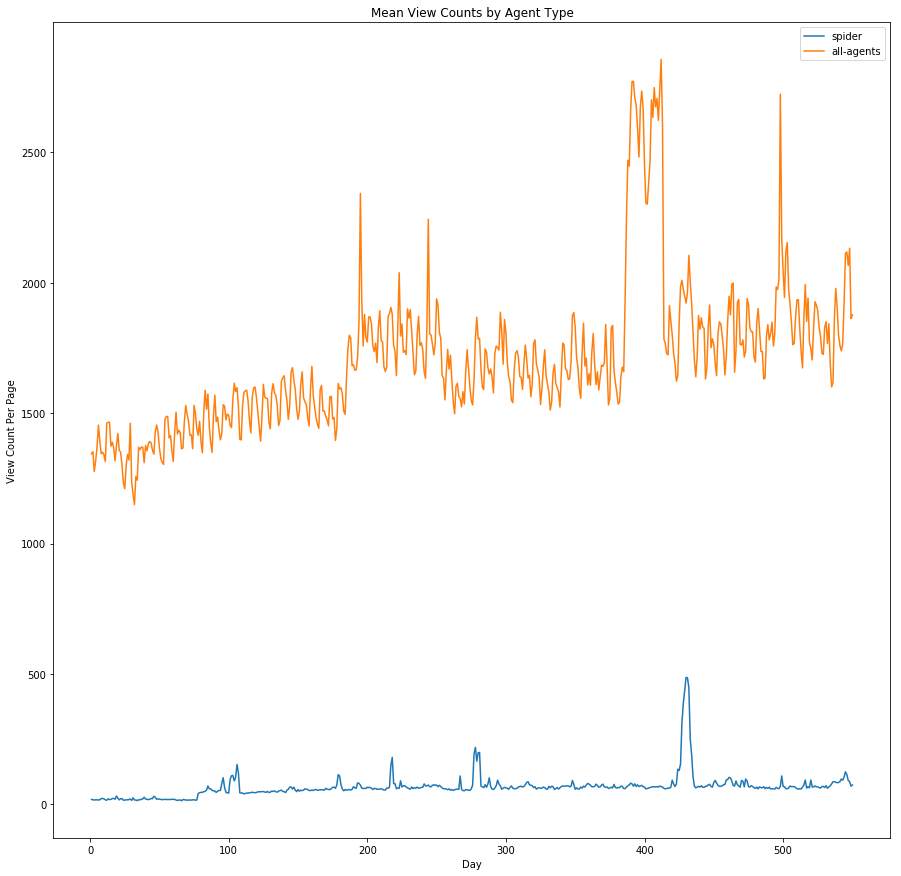

In [80]:
agent_dict, agent_mean = feature_evaluation('Agent', np.mean)

plot_trend(agent_mean)
plt.xlabel('Day')
plt.ylabel('View Count Per Page')
plt.title('Mean View Counts by Agent Type')
plt.legend()
plt.show()

There are only two categories of agents: spiders and all types of agents. The spider series has pretty low overall mean view counts, with small spikes throughout the period. The all agents group looks very similar to the time series for the English language plot. 